In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [5]:
df1 = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json",lines = True)
df2 = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines = True)

In [13]:
df = pd.concat([df1,df2],sort = False)
df.tail()


,is_sarcastic,headline,article_link
26704,0,american politics in moral free-fall,https://www.huffingtonpost.com/entry/american-...
26705,0,america's best 20 hikes,https://www.huffingtonpost.com/entry/americas-...
26706,0,reparations and obama,https://www.huffingtonpost.com/entry/reparatio...
26707,0,israeli ban targeting boycott supporters raise...,https://www.huffingtonpost.com/entry/israeli-b...
26708,0,gourmet gifts for the foodie 2014,https://www.huffingtonpost.com/entry/gourmet-g...


Text(0.5, 1.0, 'Data Distribution')

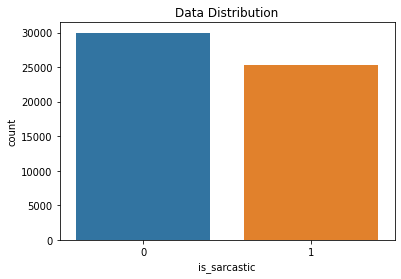

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = "is_sarcastic", data = df)
plt.title("Data Distribution")

Data distribution seems quite workable.

Removing punctuation and unnecessary stop words.
Using stemmer to get similar results for different forms of the same words

In [18]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

stop_words =set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import PorterStemmer 

def preprocess(text):
  word_list = []
  tok = tokenizer.tokenize(text)
  for word in tok:
    if word not in stop_words:
      word_list.append(stemmer.stem(word))
  return " ".join(word_list)

In [19]:
x_data = df["headline"].apply(preprocess)
x_data.tail()

26704                       american polit moral free fall
26705                                 america best 20 hike
26706                                          repar obama
26707    isra ban target boycott support rais alarm abroad
26708                              gourmet gift foodi 2014
Name: headline, dtype: object

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, df['is_sarcastic'].values, test_size=0.10, random_state=42)

Using tf-idf to further minimize the weight of unnecessary words.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

Important features:

In [24]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).head()

,idf_weights
trump,3.761485
new,3.874750
man,3.943616
year,4.528814
get,4.548165


In [26]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [ ]:
Naive Bayes Classifier:

In [27]:
BernModel = BernoulliNB()
BernModel.fit(x_train_tfidf, y_train)
print(f"Training Score : {BernModel.score(x_train_tfidf, y_train)}")
print(f"Test Score : {BernModel.score(x_test_tfidf, y_test)}")

Training Score : 0.8901496134150015
Test Score : 0.8521597686607627


In [ ]:
It gives a decent 85% test accuracy

Logistic Regression:

In [29]:
LogModel = LogisticRegression()
LogModel.fit(x_train_tfidf,y_train)
print(f"Training Score : {LogModel.score(x_train_tfidf, y_train)}")
print(f"Test Score : {LogModel.score(x_test_tfidf, y_test)}")

Training Score : 0.8898483783512401
Test Score : 0.8424001445870233


Logistics regression also gives a decent 84% accuracy.

Random Forest Classifier:

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train_tfidf,y_train)
print(f"Training Score : {rf.score(x_train_tfidf, y_train)}")
print(f"Test Score : {rf.score(x_test_tfidf, y_test)}")

Training Score : 1.0
Test Score : 0.9683715886499187


Random Forest gives very high accuracy.(almost 97%)

A combination of all the three classifiers:

In [31]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier([('rf',rf), ('lr',LogModel),  ('bm',BernModel)])
voting.fit(x_train_tfidf,y_train)
print(f"Training Score : {voting.score(x_train_tfidf, y_train)}")
print(f"Test Score : {voting.score(x_test_tfidf, y_test)}")


Training Score : 0.9254744452254242
Test Score : 0.8863184529188506


High accuracy of about 89%

Confusion Matrix:

Text(0.5, 1.0, 'Confusion Matrix for Voting Classifier')

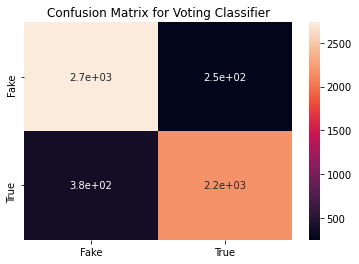

In [32]:
from sklearn import metrics
pred = voting.predict(x_test_tfidf)
cm=metrics.confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm, index = ["Fake", "True"], columns=["Fake", "True"])
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for Voting Classifier")

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

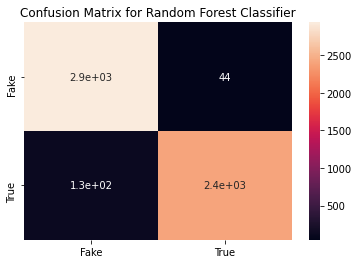

In [34]:
pred = rf.predict(x_test_tfidf)
cm=metrics.confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm, index = ["Fake", "True"], columns=["Fake", "True"])
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for Random Forest Classifier")

Random Forest classifier is better than the combination of all three classifiers

Now using LSTMs to see if they make any improvement over our previous classifiers

In [40]:
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten, LSTM, Input, Embedding,CuDNNLSTM
from keras.layers import BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.utils.np_utils import to_categorical


from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization , MaxPooling2D, Activation

Tokenizing to integer encodings and padding sequences.
Using only a maximum of 20 words per headline as long sequences are difficult to learn on.

In [53]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data)
sequences = tokenizer.texts_to_sequences(x_data.values)
sequences = pad_sequences(sequences, padding = "post", maxlen = 20)
sequences[0]

array([10733,   332,   309,  5547,  2031,   647,  1074,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [54]:
vocab_len = len(tokenizer.word_index)
maxlen = sequences.shape[1]

Creating model and adding an embedding layer.

In [56]:
LR = 1e-2
inp = Input(shape = (None,))
emb = Embedding(vocab_len+1, 64)(inp)
lstm =  LSTM(64)
lstmout =lstm(emb)
dense = Dense(1,activation = "sigmoid")
out = dense(lstmout)
model = Model(inp, out)

In [57]:
from keras.losses import categorical_crossentropy
model.compile(optimizer = Adam(LR), loss = "binary_crossentropy", metrics = ["accuracy"])


In [58]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          1150080   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,183,169
Trainable params: 1,183,169
Non-trainable params: 0
_________________________________________________________________


In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sequences, df['is_sarcastic'].values, test_size=0.10, random_state=42)

In [60]:
model.fit(x_train,y_train, batch_size = 128, epochs = 100,validation_data = (x_test, y_test), callbacks =[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2), ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 49795 samples, validate on 5533 samples
Epoch 1/100
49795/49795 [==============================] - 13s 264us/step - loss: 0.4144 - accuracy: 0.8092 - val_loss: 0.3090 - val_accuracy: 0.8787
Epoch 2/100
49795/49795 [==============================] - 12s 251us/step - loss: 0.1961 - accuracy: 0.9250 - val_loss: 0.2363 - val_accuracy: 0.9156
Epoch 3/100
49795/49795 [==============================] - 13s 253us/step - loss: 0.0984 - accuracy: 0.9640 - val_loss: 0.1874 - val_accuracy: 0.9362
Epoch 4/100
49795/49795 [==============================] - 13s 252us/step - loss: 0.0566 - accuracy: 0.9811 - val_loss: 0.1786 - val_accuracy: 0.9541
Epoch 5/100
49795/49795 [==============================] - 13s 268us/step - loss: 0.0341 - accuracy: 0.9885 - val_loss: 0.1652 - val_accuracy: 0.9583
Epoch 6/100
49795/49795 [==============================] - 12s 250us/step - loss: 0.0273 - accuracy: 0.9916 - val_loss: 0.1881 - val_accuracy: 0.9590
Epoch 7/100
49795/49795 [==========================

The model gives a very high accuracy of around 96%

Text(0.5, 1.0, 'Confusion Matrix for LSTM model')

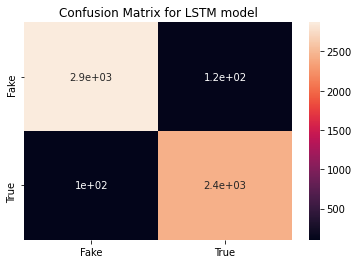

In [72]:
pred = model.predict(x_test)
pred = pred.reshape(-1)
pred
count = 0
for i in pred:
    if i< 0.5:
        pred[count] = 0
    else:
        pred[count] = 1
    count+=1
cm=metrics.confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm, index = ["Fake", "True"], columns=["Fake", "True"])
sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix for LSTM model")

Our LSTM model is giving a high accuracy but it doesn't outperform the Random Forest Classifier.
Additionally, Random Forest Classifier was faster to train.